## Praca domowa 2

### Nikola Miszalska

#### TODO:
- Przygotować dane
- podzielić na zbiory treningowy, walidacyjny i testowy
- Przetestować Random Forest oraz XGBoost na przykładowych zadaniach regresji i klasyfikacji
-  Dla każdego z problemów należy wyszkolić oba modele porównując uzyskane przez nie wyniki np. accuracy/rmse na zbiorze walidacyjnym
- dla każdego modelu należy przetestować kilka różnych zestawów hiperparametrów, takich jak np. n_estimators, max_depth i omówić ich wpływ na generalizacje modelu.

#### Ładowanie bibliotek:

In [49]:
import pandas as pd
import math
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler ,PolynomialFeatures,minmax_scale,MaxAbsScaler ,LabelEncoder

from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

from xgboost import XGBRegressor

In [58]:
air_test = pd.read_csv("data/airline_passenger_satisfaction/test.csv")
air_train = pd.read_csv("data/airline_passenger_satisfaction/train.csv")
car_train = pd.read_csv("data/car_prices_poland/car_prices_poland.csv")

## Zbiór danych airline_passenger_satisfaction

#### Przygotowanie danych

In [7]:
air_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

Mamy braki danych w kolumnie Arrival Delay in Minutes, jednak jest ich bardzo mało.

In [8]:
air_train.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [3]:
air_train["Arrival Delay in Minutes"] = air_train["Arrival Delay in Minutes"].fillna(air_train["Arrival Delay in Minutes"].mean())

In [59]:
air_test["Arrival Delay in Minutes"] = air_test["Arrival Delay in Minutes"].fillna(air_test["Arrival Delay in Minutes"].mean())

In [10]:
air_train.head()


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [40]:
for col in ['Flight Distance','Age','Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    transf = air_train[col].values.reshape(-1,1)
    scaler = StandardScaler().fit(transf)
    air_train[col] = scaler.transform(transf)
    transf = air_test[col].values.reshape(-1,1)
    air_test[col] = scaler.transform(transf)

In [5]:
air_train["Class"].unique()

array(['Eco Plus', 'Business', 'Eco'], dtype=object)

In [14]:
air_train["satisfaction"].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

In [6]:
air_train['Gender'] = (air_train['Gender'] == 'Female')*1
air_train['Customer Type'] = (air_train['Customer Type'] == 'Loyal Customer')*1
air_train["Type of Travel"] = (air_train["Type of Travel"]=='Personal Travel')*1
air_train["satisfaction"] = (air_train["satisfaction"] == "satisfied")*1

In [61]:
air_test['Gender'] = (air_test['Gender'] == 'Female')*1
air_test['Customer Type'] = (air_test['Customer Type'] == 'Loyal Customer')*1
air_test["Type of Travel"] = (air_test["Type of Travel"]=='Personal Travel')*1
air_test["satisfaction"] = (air_test["satisfaction"] == "satisfied")*1

In [7]:
air_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,0,1,-1.745279,1,Eco Plus,-0.731539,3,4,...,5,4,3,4,4,5,5,0.266393,0.073014,0
1,1,5047,0,0,-0.951360,0,Business,-0.957184,3,2,...,1,1,5,3,1,4,1,-0.361375,-0.237539,0
2,2,110028,1,1,-0.885200,0,Business,-0.047584,2,2,...,5,4,3,4,4,4,5,-0.387532,-0.392816,1
3,3,24026,1,1,-0.951360,0,Business,-0.629246,2,5,...,2,2,5,3,1,4,2,-0.099805,-0.159901,0
4,4,119299,0,1,1.430397,0,Business,-0.978244,3,3,...,3,3,4,4,3,3,3,-0.387532,-0.392816,1


Usuwam nieistotne kolumny.

In [ ]:
air_train = air_train.drop(["Unnamed: 0","id"], axis=1)

In [62]:
air_test = air_test.drop(["Unnamed: 0","id"], axis=1)

In [66]:
air_test.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,1,0.817887,0,Eco,-1.035171,5,4,3,4,...,5,5,5,5,2,5,5,0.953810,0.781143,1
1,1,1,-0.239238,0,Business,1.671443,1,1,3,1,...,4,4,4,4,3,4,5,-0.382286,-0.393543,1
2,0,0,-1.296363,0,Eco,-1.003128,2,0,2,4,...,2,4,1,3,2,2,2,-0.382286,-0.393543,0
3,0,1,0.289325,0,Business,2.186131,0,0,0,2,...,1,1,1,1,3,1,4,-0.382286,-0.233358,1
4,1,1,0.619676,0,Eco,-0.011804,2,3,4,3,...,2,2,2,2,4,2,4,-0.382286,0.140405,1


In [10]:
encoded = pd.get_dummies(air_train[["Class"]].astype(str))
encoded = encoded.drop(["Class_Eco"], axis = 1)
air_train = air_train.drop(["Class"], axis=1)
air_train = pd.concat([air_train, encoded], axis = 1)

In [67]:
encoded = pd.get_dummies(air_test[["Class"]].astype(str))
encoded = encoded.drop(["Class_Eco"], axis = 1)
air_test = air_test.drop(["Class"], axis=1)
air_test = pd.concat([air_test, encoded], axis = 1)

In [11]:
air_train.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco Plus
0,0,1,-1.745279,1,-0.731539,3,4,3,1,5,...,3,4,4,5,5,0.266393,0.073014,0,0,1
1,0,0,-0.951360,0,-0.957184,3,2,3,3,1,...,5,3,1,4,1,-0.361375,-0.237539,0,1,0
2,1,1,-0.885200,0,-0.047584,2,2,2,2,5,...,3,4,4,4,5,-0.387532,-0.392816,1,1,0
3,1,1,-0.951360,0,-0.629246,2,5,5,5,2,...,5,3,1,4,2,-0.099805,-0.159901,0,1,0
4,0,1,1.430397,0,-0.978244,3,3,3,3,4,...,4,4,3,3,3,-0.387532,-0.392816,1,1,0


In [41]:
air_test.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Class_Business,Class_Eco Plus
0,1,1,0.817887,0,-1.035171,5,4,3,4,3,...,5,5,2,5,5,0.953810,0.779894,1,0,0
1,1,1,-0.239238,0,1.671443,1,1,3,1,5,...,4,4,3,4,5,-0.382286,-0.392913,1,1,0
2,0,0,-1.296363,0,-1.003128,2,0,2,4,2,...,1,3,2,2,2,-0.382286,-0.392913,0,0,0
3,0,1,0.289325,0,2.186131,0,0,0,2,3,...,1,1,3,1,4,-0.382286,-0.232985,1,1,0
4,1,1,0.619676,0,-0.011804,2,3,4,3,4,...,2,2,4,2,4,-0.382286,0.140181,1,0,0


Podział ddanych na uczace i kolumne celu

### RandomForest i XGBoost

In [24]:
air_train["satisfaction"].value_counts()

0    58879
1    45025
Name: satisfaction, dtype: int64

In [43]:
y_train = air_train['satisfaction']
X_train = air_train.drop('satisfaction', axis = 1)

In [68]:
y_test = air_test['satisfaction']
X_test = air_test.drop('satisfaction', axis = 1)

In [54]:
rf = RandomForestClassifier(random_state=123).fit(X_train, y_train)

In [56]:
rf.score(X_train, y_train)

1.0

In [69]:
rf.score(X_test, y_test)

0.9633507853403142

### XGBoost

In [75]:
xgb_cls = xgb.XGBClassifier(objective='binary:logistic', max_depth=5, use_label_encoder=False)

In [76]:
xgb_cls.fit(X_train, y_train)

[00:14:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [77]:
xgb_cls.score(X_test, y_test)

0.9634662765629812

In [78]:
xgb_cls.score(X_train, y_train)

0.9692023406221127

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

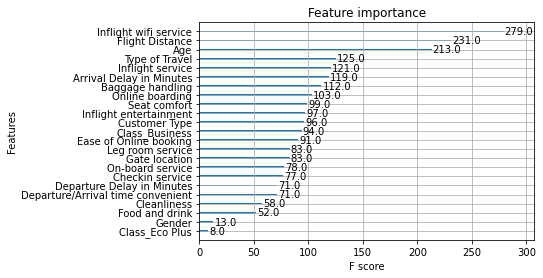

In [79]:
xgb.plot_importance(xgb_cls)

## Zbiór danych Car_prices_poland

#### Przygotowanie zbioru danych.

In [36]:
car_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB


In [37]:
car_train.isna().sum()

Unnamed: 0             0
mark                   0
model                  0
generation_name    30085
year                   0
mileage                0
vol_engine             0
fuel                   0
city                   0
province               0
price                  0
dtype: int64

Braków w kolumnie generation_name jest bardzo dużo, to ponad 25% obserwacji.

In [81]:
car_train['generation_name'].fillna('No_gen',inplace=True)

In [82]:
car_train.describe()

,Unnamed: 0,year,mileage,vol_engine,price
count,117927.000000,117927.000000,1.179270e+05,117927.000000,1.179270e+05
mean,58963.000000,2012.925259,1.409768e+05,1812.057782,7.029988e+04
std,34042.736935,5.690135,9.236936e+04,643.613438,8.482458e+04
min,0.000000,1945.000000,0.000000e+00,0.000000,5.000000e+02
25%,29481.500000,2009.000000,6.700000e+04,1461.000000,2.100000e+04
50%,58963.000000,2013.000000,1.462690e+05,1796.000000,4.190000e+04
75%,88444.500000,2018.000000,2.030000e+05,1995.000000,8.360000e+04
max,117926.000000,2022.000000,2.800000e+06,7600.000000,2.399900e+06


In [40]:
car_train.head()

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


In [83]:
car_train = car_train.drop(["Unnamed: 0"], axis=1)

In [84]:
car_train.groupby("fuel").count()

,mark,model,generation_name,year,mileage,vol_engine,city,province,price
fuel,,,,,,,,,
CNG,47,47,47,47,47,47,47,47,47
Diesel,48476,48476,48476,48476,48476,48476,48476,48476,48476
Electric,885,885,885,885,885,885,885,885,885
Gasoline,61597,61597,61597,61597,61597,61597,61597,61597,61597
Hybrid,2621,2621,2621,2621,2621,2621,2621,2621,2621
LPG,4301,4301,4301,4301,4301,4301,4301,4301,4301


Liczb aut z paliwem CNG jest tam mała że można usunąc ten typ paliwa

In [85]:
car_train.drop(car_train[car_train["fuel"] == "CNG"].index,axis = 0,inplace = True)

In [86]:
car_train.groupby("fuel").count()

,mark,model,generation_name,year,mileage,vol_engine,city,province,price
fuel,,,,,,,,,
Diesel,48476,48476,48476,48476,48476,48476,48476,48476,48476
Electric,885,885,885,885,885,885,885,885,885
Gasoline,61597,61597,61597,61597,61597,61597,61597,61597,61597
Hybrid,2621,2621,2621,2621,2621,2621,2621,2621,2621
LPG,4301,4301,4301,4301,4301,4301,4301,4301,4301


Kategoria province i city są od siebie mocno zalezne, dlatego mozna usunąć jedną z kolumn

In [87]:
car_train.groupby("province").count()

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,price
province,,,,,,,,,
(,1,1,1,1,1,1,1,1,1
Berlin,3,3,3,3,3,3,3,3,3
Dolnośląskie,8838,8838,8838,8838,8838,8838,8838,8838,8838
Kujawsko-pomorskie,5371,5371,5371,5371,5371,5371,5371,5371,5371
Lubelskie,4739,4739,4739,4739,4739,4739,4739,4739,4739
Lubuskie,2742,2742,2742,2742,2742,2742,2742,2742,2742
Mazowieckie,22208,22208,22208,22208,22208,22208,22208,22208,22208
Małopolskie,9751,9751,9751,9751,9751,9751,9751,9751,9751
Moravian-Silesian Region,35,35,35,35,35,35,35,35,35


In [88]:
car_train.drop(car_train[car_train["province"] == "Niedersachsen"].index,axis = 0,inplace = True)
car_train.drop(car_train[car_train["province"] == "Nordrhein-Westfalen"].index,axis = 0,inplace = True)
car_train.drop(car_train[car_train["province"] == "Berlin"].index,axis = 0,inplace = True)
car_train.drop(car_train[car_train["province"] == "("].index,axis = 0,inplace = True)
car_train.drop(car_train[car_train["province"] == "Wiedeń"].index,axis = 0,inplace = True)

In [89]:
car_train.groupby("province").count()


,mark,model,generation_name,year,mileage,vol_engine,fuel,city,price
province,,,,,,,,,
Dolnośląskie,8838,8838,8838,8838,8838,8838,8838,8838,8838
Kujawsko-pomorskie,5371,5371,5371,5371,5371,5371,5371,5371,5371
Lubelskie,4739,4739,4739,4739,4739,4739,4739,4739,4739
Lubuskie,2742,2742,2742,2742,2742,2742,2742,2742,2742
Mazowieckie,22208,22208,22208,22208,22208,22208,22208,22208,22208
Małopolskie,9751,9751,9751,9751,9751,9751,9751,9751,9751
Moravian-Silesian Region,35,35,35,35,35,35,35,35,35
Opolskie,2073,2073,2073,2073,2073,2073,2073,2073,2073
Podkarpackie,3550,3550,3550,3550,3550,3550,3550,3550,3550


In [90]:
car_train = car_train.drop(["city"], axis=1)

In [91]:
car_train.head()

,mark,model,generation_name,year,mileage,vol_engine,fuel,province,price
0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Mazowieckie,35900
1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Śląskie,78501
2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Opolskie,27000
3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Opolskie,30800
5,opel,combo,gen-d-2011,2017,121203,1598,Diesel,Mazowieckie,51900


In [92]:
for col in ['mileage','vol_engine', "price"]:
    transf = car_train[col].values.reshape(-1,1)
    scaler = StandardScaler().fit(transf)
    car_train[col] = scaler.transform(transf)

In [93]:
car_train = car_train.drop(["generation_name"], axis = 1)

In [94]:
car_train.head()

,mark,model,year,mileage,vol_engine,fuel,province,price
0,opel,combo,2015,-0.015063,-0.876468,Diesel,Mazowieckie,-0.405687
1,opel,combo,2018,-1.179680,-0.486537,Diesel,Śląskie,0.096456
2,opel,combo,2015,1.488318,-0.332739,Diesel,Opolskie,-0.510592
3,opel,combo,2016,-1.010698,-0.876468,Diesel,Opolskie,-0.465801
5,opel,combo,2017,-0.213880,-0.332739,Diesel,Mazowieckie,-0.217093


In [95]:
LE=LabelEncoder()
LE.fit(car_train["mark"])
car_train["Mark"]=LE.transform(car_train["mark"])

LE2=LabelEncoder()
LE2.fit(car_train["fuel"])
car_train["Fuel"]=LE2.transform(car_train["fuel"])

LE3=LabelEncoder()
LE2.fit(car_train["model"])
car_train["Model"]=LE2.transform(car_train["model"])

LE4=LabelEncoder()
LE2.fit(car_train["province"])
car_train["Province"]=LE2.transform(car_train["province"])

In [96]:
car_train = car_train.drop(["mark", "model", "fuel", "province"], axis=1)

In [97]:
car_train.head()

,year,mileage,vol_engine,price,Mark,Fuel,Model,Province
0,2015,-0.015063,-0.876468,-0.405687,15,0,89,4
1,2018,-1.179680,-0.486537,0.096456,15,0,89,15
2,2015,1.488318,-0.332739,-0.510592,15,0,89,7
3,2016,-1.010698,-0.876468,-0.465801,15,0,89,7
5,2017,-0.213880,-0.332739,-0.217093,15,0,89,4


### RandomForest 

In [98]:
y = car_train['price']
X = car_train.drop('price', axis = 1)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [100]:
RFR=RandomForestRegressor(n_estimators=10,random_state=42)
RFR.fit(X_train,y_train)
RFR.score(X_test,y_test)

0.9247068672328539

In [115]:
RFR=RandomForestRegressor(max_depth=10, n_estimators= 300, random_state=50)
RFR.fit(X_train,y_train)

RFR.score(X_test,y_test)

0.9088213255122094

### XGBoost

In [102]:
xgb_rgr = XGBRegressor(n_estimators=1000, max_depth=5)

In [103]:
xgb_rgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [104]:
xgb_rgr.score(X_test, y_test)

0.9424717871945261

In [105]:
xgb_rgr.score(X_train, y_train)

0.9843043021997232